#### 1. Load Dataset

In [33]:
import pandas as pd
import numpy as np
import zipfile
import urllib.request
import os

# Step 1: Define the URL for the dataset
url = "https://archive.ics.uci.edu/static/public/240/human+activity+recognition+using+smartphones.zip"
zip_file = "human_activity_recognition.zip"

# Step 2: Download the dataset if it doesn’t already exist
if not os.path.exists(zip_file):
    print("Downloading dataset...")
    urllib.request.urlretrieve(url, zip_file)

# Step 3: Extract the dataset
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall("human_activity_recognition")

# Step 4: Extract inner zip file within the extracted folder
inner_zip_path = "human_activity_recognition/UCI HAR Dataset.zip"
with zipfile.ZipFile(inner_zip_path, 'r') as inner_zip_ref:
    inner_zip_ref.extractall("UCI_HAR_Dataset")

# Step 5: Load the training and testing data
train_data_path = "UCI_HAR_Dataset/UCI HAR Dataset/train/X_train.txt"
train_labels_path = "UCI_HAR_Dataset/UCI HAR Dataset/train/y_train.txt"
test_data_path = "UCI_HAR_Dataset/UCI HAR Dataset/test/X_test.txt"
test_labels_path = "UCI_HAR_Dataset/UCI HAR Dataset/test/y_test.txt"

train_data = pd.read_csv(train_data_path, sep='\s+', header=None)
train_labels = pd.read_csv(train_labels_path, header=None)
test_data = pd.read_csv(test_data_path, sep='\s+', header=None)
test_labels = pd.read_csv(test_labels_path, header=None)

# Step 6: Combine train and test data for further processing
data = pd.concat([train_data, test_data], ignore_index=True)
labels = pd.concat([train_labels, test_labels], ignore_index=True)

# Display dataset dimensions and a sample
print("Dimensions of the dataset:", data.shape)
print("Sample data:\n", data.head(5))

<>:31: SyntaxWarning: invalid escape sequence '\s'
<>:33: SyntaxWarning: invalid escape sequence '\s'
<>:31: SyntaxWarning: invalid escape sequence '\s'
<>:33: SyntaxWarning: invalid escape sequence '\s'
/var/folders/0q/w_16bdwx7rs5fyp7nm2f23lr0000gn/T/ipykernel_93932/4045650042.py:31: SyntaxWarning: invalid escape sequence '\s'
  train_data = pd.read_csv(train_data_path, sep='\s+', header=None)
/var/folders/0q/w_16bdwx7rs5fyp7nm2f23lr0000gn/T/ipykernel_93932/4045650042.py:33: SyntaxWarning: invalid escape sequence '\s'
  test_data = pd.read_csv(test_data_path, sep='\s+', header=None)


Dimensions of the dataset: (10299, 561)
Sample data:
         0         1         2         3         4         5         6     
0  0.288585 -0.020294 -0.132905 -0.995279 -0.983111 -0.913526 -0.995112  \
1  0.278419 -0.016411 -0.123520 -0.998245 -0.975300 -0.960322 -0.998807   
2  0.279653 -0.019467 -0.113462 -0.995380 -0.967187 -0.978944 -0.996520   
3  0.279174 -0.026201 -0.123283 -0.996091 -0.983403 -0.990675 -0.997099   
4  0.276629 -0.016570 -0.115362 -0.998139 -0.980817 -0.990482 -0.998321   

        7         8         9    ...       551       552       553       554   
0 -0.983185 -0.923527 -0.934724  ... -0.074323 -0.298676 -0.710304 -0.112754  \
1 -0.974914 -0.957686 -0.943068  ...  0.158075 -0.595051 -0.861499  0.053477   
2 -0.963668 -0.977469 -0.938692  ...  0.414503 -0.390748 -0.760104 -0.118559   
3 -0.982750 -0.989302 -0.938692  ...  0.404573 -0.117290 -0.482845 -0.036788   
4 -0.979672 -0.990441 -0.942469  ...  0.087753 -0.351471 -0.699205  0.123320   

        555   

In [34]:
labels.value_counts() 

6    1944
5    1906
4    1777
1    1722
2    1544
3    1406
Name: count, dtype: int64

#### 2. implement SOM

In [35]:
import seaborn as sns
from matplotlib import pyplot as plt
from collections import Counter

In [36]:
from sklearn.metrics.cluster import silhouette_score, contingency_matrix

In [41]:
class SOM:
  def __init__(self, map_dim,lr_0=0.3,r_0=None,lr_decay=0.05, r_decay=0.05, ns_function='circular') -> None:
    """
    parameters:
    map_dim: [map_w, map_h, f] - dimensions of the map weights
    ns_function: 'circular' or 'linear' or 'square' - neighborhood function
    """
    self.map = np.random.random(size=[map_dim[0],map_dim[1],map_dim[2]])
    self.lr = lr_0
    self.r = map_dim[0] if r_0 is None else r_0
    self.lr_decay = lr_decay
    self.r_decay = r_decay
    self.ns_function = ns_function
    
  def train(self, X, epochs=100, threshold=1e-3):
    losses = []
    dead_n = []
    length = len(X)
    for epoch in range(epochs):
      prev_map = self.map.copy()
      shuffle_idx = np.random.permutation(length)
      for i in range(length):
        x = X[shuffle_idx[i]]
        winner = self.find_winner(x) # [iw,jw]
        n_str = getattr(self, f'neighbor_strength_{self.ns_function}')(winner)
        self.update_weights(x, n_str, length)
      
      losses.append(self.loss(prev_map))
      
      if epoch % 10 == 0:
        print(f'in epoch {epoch}: loss = {losses[-1]} lr = {self.lr} r = {self.r}')
        dead_n.append(self.get_num_of_dead_neurons(X))
      
      self.lr = self.lr - self.lr * self.lr_decay
      self.r = self.r - self.r * self.r_decay
      
      if losses[-1] < threshold:
        print(f'Converged at epoch:{epoch}')
        break
    
    return losses, dead_n
    
  def loss(self,prev_map):
    return np.linalg.norm(prev_map - self.map)
  
  def find_winner(self, x):
    rep_x = np.tile(x, (self.map.shape[0], self.map.shape[1], 1))
    dist = np.sum((self.map - rep_x)**2,axis=2)
    return np.unravel_index(np.argmin(dist, axis=None), dist.shape)
    
  def neighbor_strength_circular(self, winner):
    n_s = np.zeros(self.map.shape[:2])
    iw, jw = winner
    n_s[iw, jw] = 1
    R = int(self.r)
    # range over radius to update neighbors of winner in circular neighborhood
    for i in range(-R, R):
      for j in range(-R, R):
        if 0<=iw + i < self.map.shape[0] and 0<=jw + j < self.map.shape[1]:
          neighbor = np.sqrt(i**2+j**2)
          n_s[iw + i, jw + j] = 0 if neighbor > R else 1/(1 + neighbor)
        
    return n_s
  
  def neighbor_strength_linear(self, winner):
    n_s = np.zeros(self.map.shape[:2])
    iw, jw = winner
    n_s[iw, jw] = 1
    R = int(self.r)
    # range over radius
    for r in range(-R, R):
      if 0<=iw + r < self.map.shape[0]:
        n_s[iw + r, jw] = 1/(1 + np.abs(r))
    return n_s
  
  def neighbor_strength_square(self, winner):
    n_s = np.zeros(self.map.shape[:2])
    iw, jw = winner
    n_s[iw, jw] = 1
    R = int(self.r)
    for r in range(1,R):
      if 0<=iw + r < self.map.shape[0]:
        n_s[iw + r, jw] = 1/r
      if 0<=iw - r < self.map.shape[0]:
        n_s[iw - r, jw] = 1/r
      if 0<=jw + r < self.map.shape[1]:
        n_s[iw, jw + r] = 1/r
      if 0<=jw - r < self.map.shape[1]:
        n_s[iw, jw - r] = 1/r
    
    return n_s
  
  def update_weights(self, x, n_str, length):
    n_s = np.tile(n_str, (self.map.shape[2], 1, 1)).transpose()
    
    rep_x = np.tile(x, (self.map.shape[0], self.map.shape[1], 1))
    delta = rep_x - self.map
    
    self.map += (self.lr/length) * np.multiply(n_s,delta)
  
  def visualize(self, X, y):
    self.cluster_map = np.zeros((self.map.shape[0], self.map.shape[1]), dtype=int)
    neuron_labels = { (i, j): [] for i in range(self.map.shape[0]) for j in range(self.map.shape[1]) }

    for i, x in enumerate(X):
        winner = self.find_winner(x)
        neuron_labels[winner].append(y[i][0])

    for (i, j), labels in neuron_labels.items():
        if labels:
            most_common_label = Counter(labels).most_common(1)[0][0]
            self.cluster_map[i, j] = most_common_label

    unique_labels = np.unique(y)
    num_labels = len(unique_labels)
    cmap = sns.color_palette("tab10", num_labels)  # Use 'tab10' or another qualitative colormap

    plt.figure(figsize=(8, 8))
    sns.heatmap(
        self.cluster_map,
        cmap=sns.color_palette(cmap, as_cmap=True),  # Use qualitative colormap
        linewidths=0.5,
        annot=True,  # Annotate with the most frequent cluster label
        fmt="d",  # Integer formatting for annotations
        cbar_kws={"label": "Cluster Label"}
    )
    plt.title("SOM Cluster Visualization")
    plt.xlabel("Neuron X Coordinate")
    plt.ylabel("Neuron Y Coordinate")
    plt.show()

  def extract_features(self, x):
    rep_x = np.tile(x, (self.map.shape[0], self.map.shape[1], 1))
    dist = np.sum((self.map - rep_x)**2,axis=2)
    return 1/(1 + dist)
  
  def get_num_of_dead_neurons(self, X):
    # count number of neurons that have not been activated
    count = np.zeros(shape=(self.map.shape[0], self.map.shape[1]), dtype=int)
    for i in range(len(X)):
      x = X[i]
      winner = self.find_winner(x)
      count[winner] = 1
    return np.sum(count == 0, axis=None)
  
  def convergence_plot(self, losses):
    plt.plot(losses)
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.show()
    
  def dead_neurons_plot(self, dead_n):
    plt.plot(dead_n)
    plt.xlabel('epochs')
    plt.ylabel('number of dead neurons')
    plt.show()
    
  def purity_score(self, X, y_true):
    y_pred = []
    for x in X:
        winner = self.find_winner(x)
        cluster_label = self.cluster_map[winner] 
        y_pred.append(cluster_label)  
    cm = contingency_matrix(y_true, y_pred)
    
    # Calculate the purity score
    return np.sum(np.amax(cm, axis=0)) / np.sum(cm)
    
  def silhouette_score(self, X):
    y_pred = []
    for x in X:
      winner = self.find_winner(x)  # Winner is a tuple (i, j)
      cluster_label = self.cluster_map[winner]
      y_pred.append(cluster_label)
    return silhouette_score(X, y_pred)

##### 3.1 different map sizes

in epoch 0: loss = 14.397334641212693 lr = 0.3 r = 5
in epoch 10: loss = 2.131375436575027 lr = 0.17962108177151367 r = 2.9936846961918944
in epoch 20: loss = 0.4383532909417482 lr = 0.10754577672256267 r = 1.792429612042711
in epoch 30: loss = 0.22580974189054953 lr = 0.06439162918288127 r = 1.0731938197146877
in epoch 40: loss = 0.07196400109400669 lr = 0.038553646969531015 r = 0.6425607828255168
in epoch 50: loss = 0.04014724634285649 lr = 0.023083492583014002 r = 0.38472487638356667
in epoch 60: loss = 0.0230575753116762 lr = 0.013820939696085627 r = 0.23034899493476044
in epoch 70: loss = 0.013457515092071586 lr = 0.008275107131032518 r = 0.13791845218387533
in epoch 80: loss = 0.007938371785096536 lr = 0.004954612315504093 r = 0.08257687192506821
in epoch 90: loss = 0.0047095101012285655 lr = 0.0029665094128976982 r = 0.04944182354829496
in epoch 100: loss = 0.0028043216611767906 lr = 0.0017761587661002083 r = 0.02960264610167013
in epoch 110: loss = 0.0016734383131580574 lr = 0.

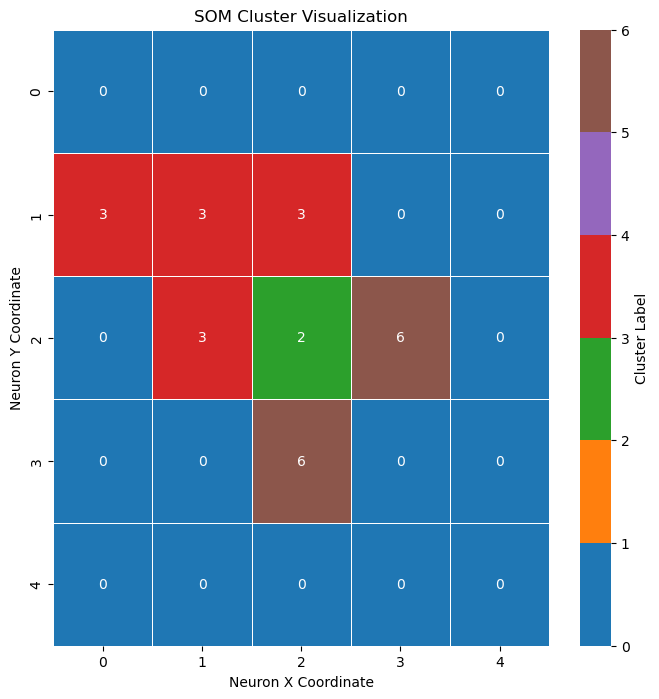

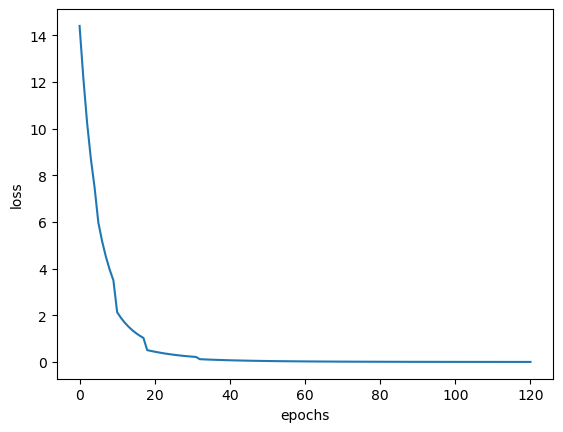

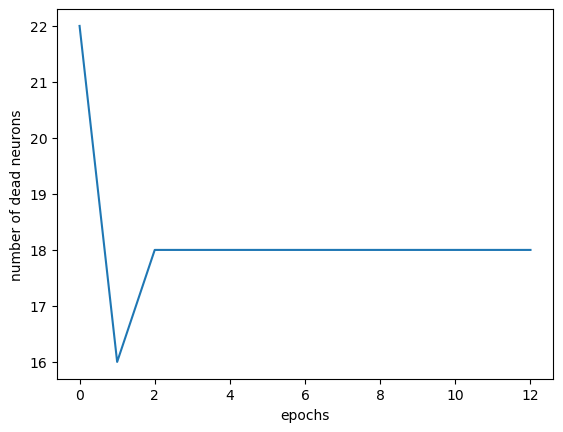

For map size (5, 5):
Number of dead neurons: 18
----------------------------------------
in epoch 0: loss = 18.539943213116498 lr = 0.3 r = 10
in epoch 10: loss = 4.438439625920552 lr = 0.17962108177151367 r = 5.987369392383789
in epoch 20: loss = 1.234775836757036 lr = 0.10754577672256267 r = 3.584859224085422
in epoch 30: loss = 0.3535653795201132 lr = 0.06439162918288127 r = 2.1463876394293755
in epoch 40: loss = 0.1107936039312027 lr = 0.038553646969531015 r = 1.2851215656510335
in epoch 50: loss = 0.039746382136650396 lr = 0.023083492583014002 r = 0.7694497527671333
in epoch 60: loss = 0.022638796646853126 lr = 0.013820939696085627 r = 0.4606979898695209
in epoch 70: loss = 0.013239178815054679 lr = 0.008275107131032518 r = 0.27583690436775066
in epoch 80: loss = 0.007814225305699004 lr = 0.004954612315504093 r = 0.16515374385013643
in epoch 90: loss = 0.004636847014379423 lr = 0.0029665094128976982 r = 0.09888364709658992
in epoch 100: loss = 0.0027616155578985826 lr = 0.00177615

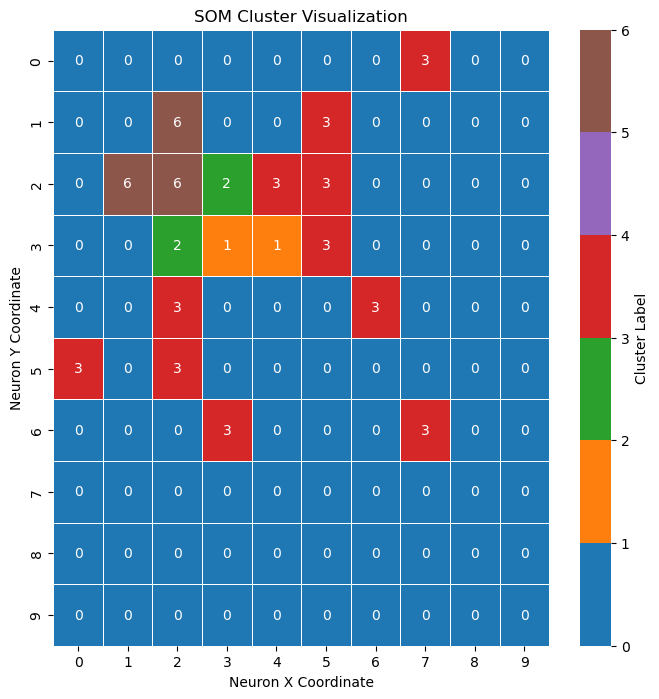

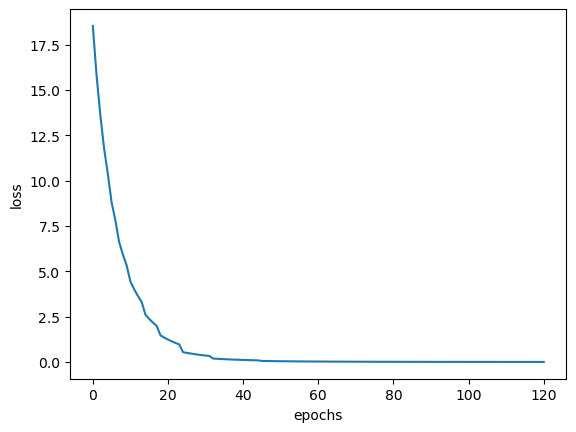

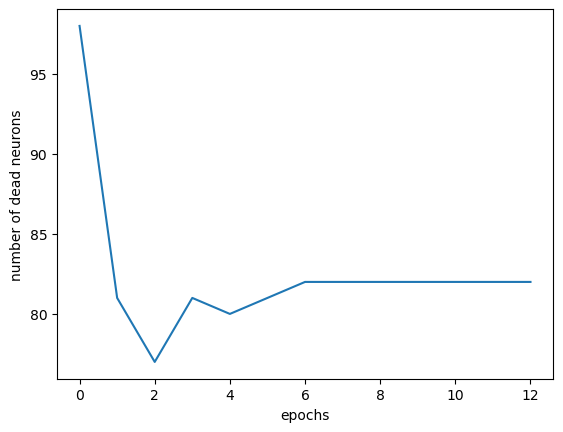

For map size (10, 10):
Number of dead neurons: 82
----------------------------------------
in epoch 0: loss = 18.804723106080374 lr = 0.3 r = 15
in epoch 10: loss = 5.705420252781611 lr = 0.17962108177151367 r = 8.981054088575682
in epoch 20: loss = 2.2861872572430912 lr = 0.10754577672256267 r = 5.377288836128134
in epoch 30: loss = 0.8752640960299155 lr = 0.06439162918288127 r = 3.219581459144064
in epoch 40: loss = 0.1453315719210383 lr = 0.038553646969531015 r = 1.9276823484765513
in epoch 50: loss = 0.08167675067109638 lr = 0.023083492583014002 r = 1.1541746291507005
in epoch 60: loss = 0.02640535753080969 lr = 0.013820939696085627 r = 0.6910469848042813
in epoch 70: loss = 0.015741941718853625 lr = 0.008275107131032518 r = 0.4137553565516259
in epoch 80: loss = 0.009409376997149178 lr = 0.004954612315504093 r = 0.24773061577520464
in epoch 90: loss = 0.005632331289350052 lr = 0.0029665094128976982 r = 0.14832547064488488
in epoch 100: loss = 0.0033686293133127375 lr = 0.001776158

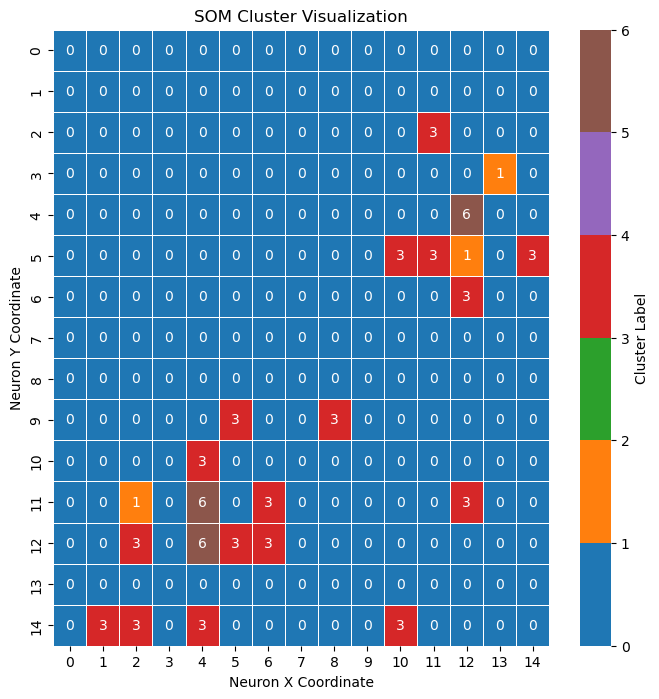

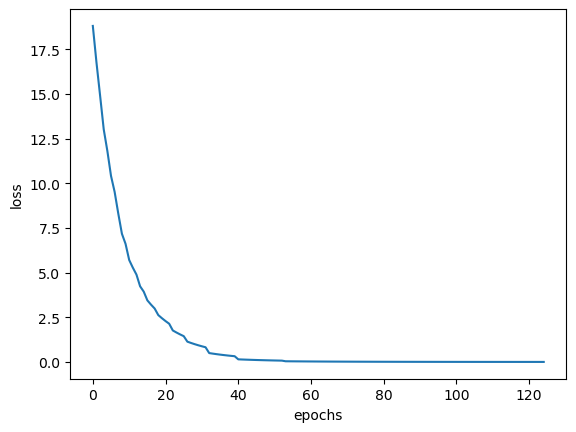

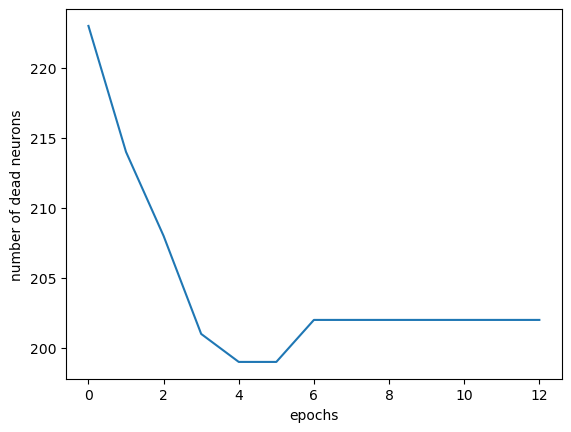

For map size (15, 15):
Number of dead neurons: 202
----------------------------------------
in epoch 0: loss = 24.107171604750935 lr = 0.3 r = 20
in epoch 10: loss = 8.290013106574962 lr = 0.17962108177151367 r = 11.974738784767577
in epoch 20: loss = 2.970402131564446 lr = 0.10754577672256267 r = 7.169718448170844
in epoch 30: loss = 0.831552636069003 lr = 0.06439162918288127 r = 4.292775278858751
in epoch 40: loss = 0.20705555549185936 lr = 0.038553646969531015 r = 2.570243131302067
in epoch 50: loss = 0.07482625524423898 lr = 0.023083492583014002 r = 1.5388995055342667
in epoch 60: loss = 0.024246831293148582 lr = 0.013820939696085627 r = 0.9213959797390417
in epoch 70: loss = 0.013930692071139478 lr = 0.008275107131032518 r = 0.5516738087355013
in epoch 80: loss = 0.008143706093788674 lr = 0.004954612315504093 r = 0.33030748770027285
in epoch 90: loss = 0.004803626510267833 lr = 0.0029665094128976982 r = 0.19776729419317984
in epoch 100: loss = 0.002850530575156928 lr = 0.001776158

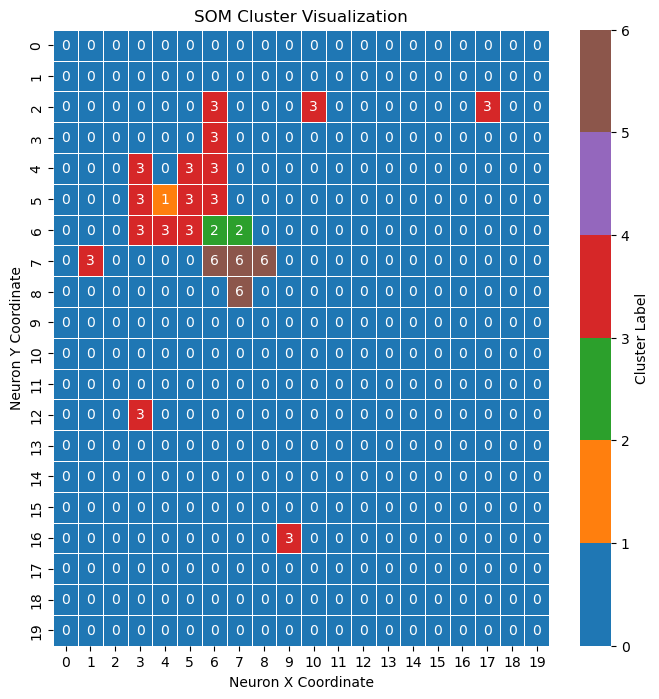

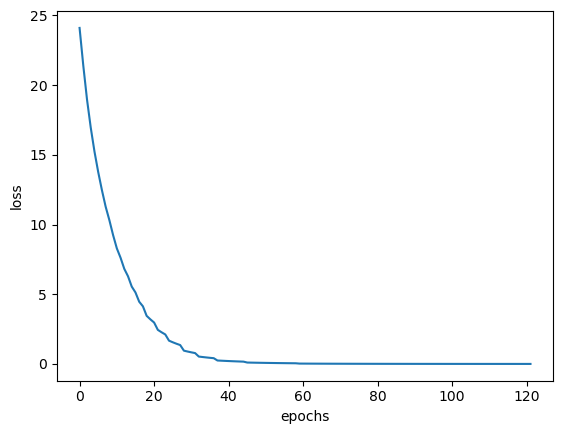

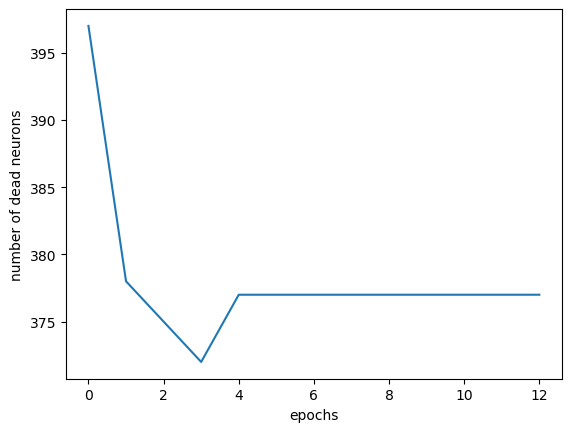

For map size (20, 20):
Number of dead neurons: 377
----------------------------------------


In [42]:
map_sizes = [(5,5),(10,10),(15,15),(20,20)]
for map_size in map_sizes:
    som = SOM(map_dim=[map_size[0], map_size[1], data.shape[1]])
    losses, dead_n = som.train(data.values, epochs=500)
    som.visualize(data.values, labels.values)
    som.convergence_plot(losses)
    som.dead_neurons_plot(dead_n)
    print(f'For map size {map_size}:')
    print(f'Number of dead neurons: {dead_n[-1]}')
    print('----------------------------------------')

# Results:
1. **Cluster Distribution and Separation:**
   - In smaller grids (5×5), clusters are tightly packed, leading to less distinction and possibly overlapping between clusters due to limited space.
   - As the grid size increases (10×10, 15×15, 20×20), clusters become more spatially separated. This reflects better representation of the input data, allowing more detailed and fine-grained clustering.

2. **Cluster Size Variation:**
   - Larger grids (20×20) allocate more neurons to represent clusters. This enables the SOM to differentiate minor variations within clusters, improving granularity.
   - Smaller grids (5×5) tend to generalize more, representing clusters with fewer neurons, potentially oversimplifying complex data distributions.

3. **Empty Neurons:**
   - Larger grids (e.g., 15×15, 20×20) exhibit many neurons that remain unutilized (cluster label `0`). This indicates the SOM has additional capacity that may not be necessary if the dataset is not sufficiently large or diverse.
   - Smaller grids (5×5, 10×10) use almost all neurons, reflecting tighter resource constraints but also potential overfitting in small datasets.

4. **Cluster Compactness:**
   - In smaller grids (e.g., 5×5), clusters appear compact but may not reflect true distributions due to spatial constraints.
   - Larger grids (e.g., 20×20) show a more natural distribution of clusters, aligning with the underlying data's structure.

5. **Dead Neurons Behavior:**
   - **5×5 Grid:** The number of dead neurons decreases until around the 15th epoch, then increases slightly between epochs 15–20, and finally stabilizes after epoch 20.
   - **10×10 Grid:** Dead neurons decrease until around the 20th epoch, show a brief increase afterward, and stabilize around epoch 60.
   - Larger grids, such as 15×15 and 20×20, take longer to stabilize due to their increased capacity and higher number of neurons.


### Conclusion:
- Use smaller SOMs for quick insights into data or when computational resources are constrained.
- Use larger SOMs for detailed analysis and fine-grained clustering, especially for complex or large datasets.
- The choice of grid size should balance data complexity, computational resources, and the desired level of detail.

##### 3.2 different neighborhood functions

in epoch 0: loss = 14.490280795685525 lr = 0.3 r = 10
in epoch 10: loss = 3.1674851744868655 lr = 0.17962108177151367 r = 5.987369392383789
in epoch 20: loss = 0.8436484469281778 lr = 0.10754577672256267 r = 3.584859224085422
in epoch 30: loss = 0.2788834123593647 lr = 0.06439162918288127 r = 2.1463876394293755
in epoch 40: loss = 0.1293220545020331 lr = 0.038553646969531015 r = 1.2851215656510335
in epoch 50: loss = 0.039793477609928664 lr = 0.023083492583014002 r = 0.7694497527671333
in epoch 60: loss = 0.022323173971489713 lr = 0.013820939696085627 r = 0.4606979898695209
in epoch 70: loss = 0.01286694567689186 lr = 0.008275107131032518 r = 0.27583690436775066
in epoch 80: loss = 0.007537487474770052 lr = 0.004954612315504093 r = 0.16515374385013643
in epoch 90: loss = 0.004452254703208706 lr = 0.0029665094128976982 r = 0.09888364709658992
in epoch 100: loss = 0.002644776103046159 lr = 0.0017761587661002083 r = 0.05920529220334026
in epoch 110: loss = 0.0015755574651210363 lr = 0.001

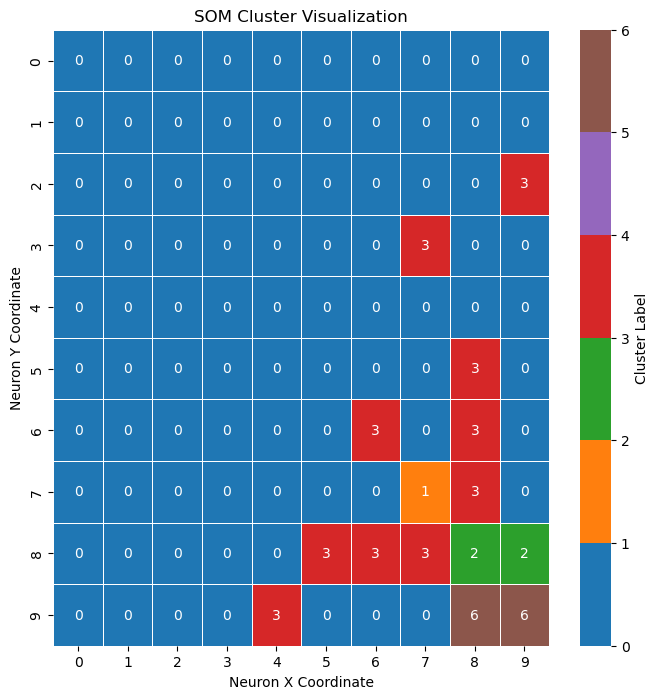

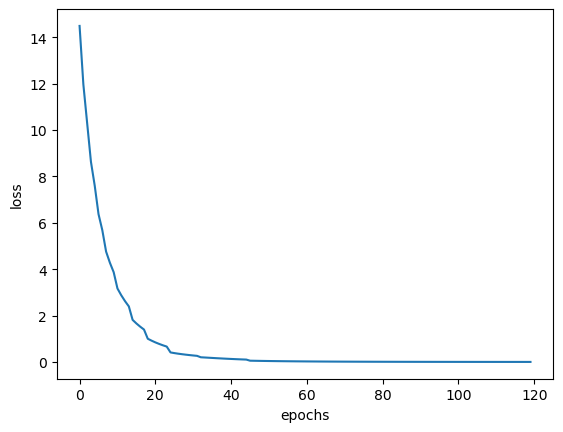

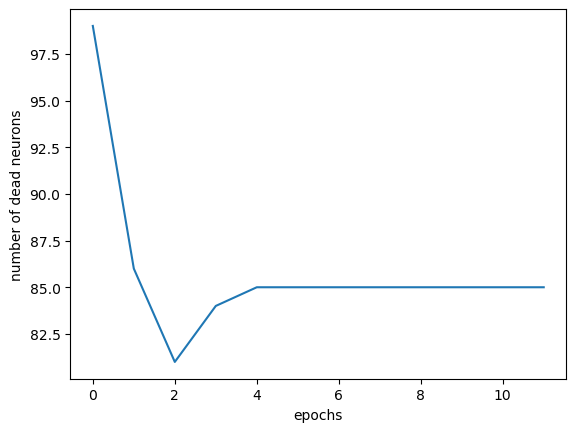

For neighborhood function circular:
Number of dead neurons: 85
Silhouette score: 0.39130012622584714
Purity score: 0.3391524139959159
----------------------------------------
in epoch 0: loss = 7.436147655911323 lr = 0.3 r = 10
in epoch 10: loss = 2.103718343579334 lr = 0.17962108177151367 r = 5.987369392383789
in epoch 20: loss = 0.8155718392510033 lr = 0.10754577672256267 r = 3.584859224085422
in epoch 30: loss = 0.3511862458131894 lr = 0.06439162918288127 r = 2.1463876394293755
in epoch 40: loss = 0.1489032757419959 lr = 0.038553646969531015 r = 1.2851215656510335
in epoch 50: loss = 0.06812418182961677 lr = 0.023083492583014002 r = 0.7694497527671333
in epoch 60: loss = 0.041839125714967125 lr = 0.013820939696085627 r = 0.4606979898695209
in epoch 70: loss = 0.02563207065400105 lr = 0.008275107131032518 r = 0.27583690436775066
in epoch 80: loss = 0.015466476515121372 lr = 0.004954612315504093 r = 0.16515374385013643
in epoch 90: loss = 0.009328190218548119 lr = 0.002966509412897698

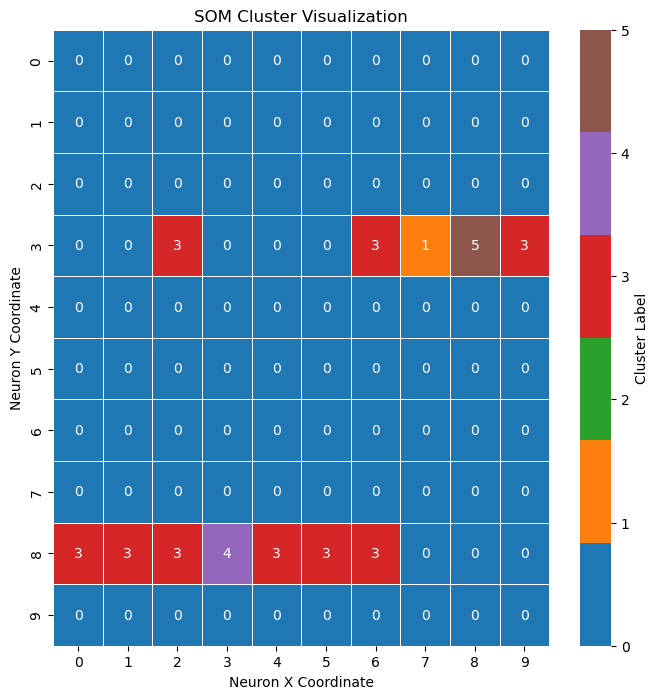

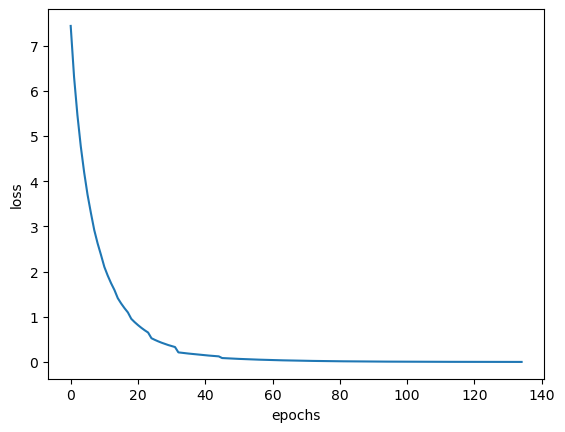

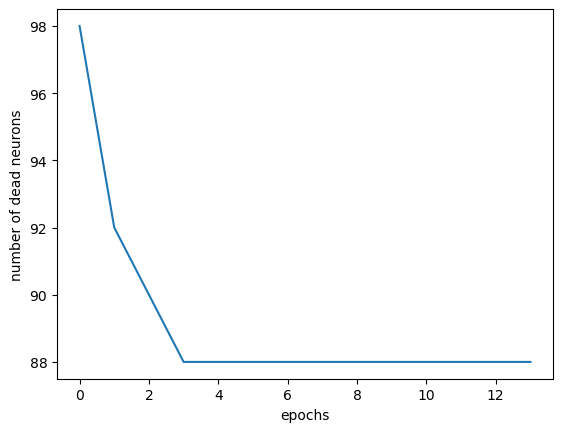

For neighborhood function linear:
Number of dead neurons: 88
Silhouette score: 0.3092533255655889
Purity score: -0.046681930552540274
----------------------------------------
in epoch 0: loss = 13.643242227807365 lr = 0.3 r = 10
in epoch 10: loss = 3.3943630670569096 lr = 0.17962108177151367 r = 5.987369392383789
in epoch 20: loss = 1.324820067455134 lr = 0.10754577672256267 r = 3.584859224085422
in epoch 30: loss = 0.752243068036641 lr = 0.06439162918288127 r = 2.1463876394293755
in epoch 40: loss = 0.08196327383828785 lr = 0.038553646969531015 r = 1.2851215656510335
in epoch 50: loss = 0.042310824520239924 lr = 0.023083492583014002 r = 0.7694497527671333
in epoch 60: loss = 0.02316798397393641 lr = 0.013820939696085627 r = 0.4606979898695209
in epoch 70: loss = 0.013149705034237343 lr = 0.008275107131032518 r = 0.27583690436775066
in epoch 80: loss = 0.007624549875284036 lr = 0.004954612315504093 r = 0.16515374385013643
in epoch 90: loss = 0.004476627009845194 lr = 0.0029665094128976

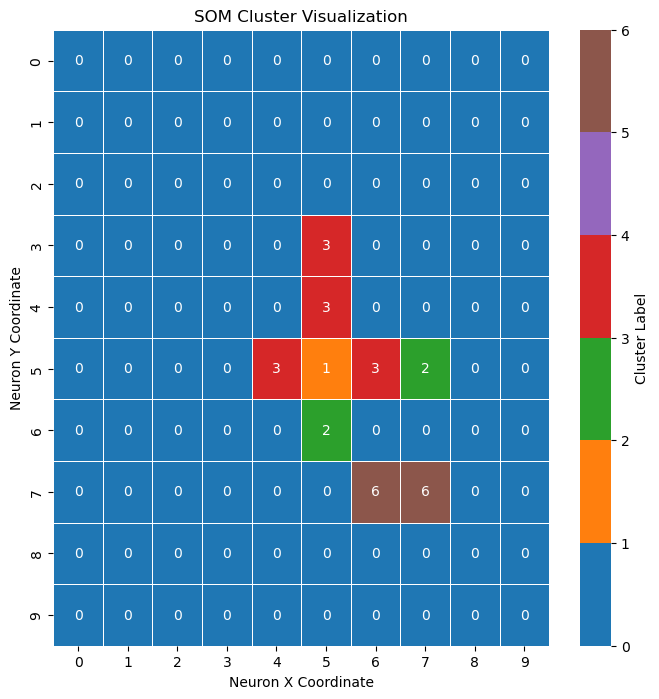

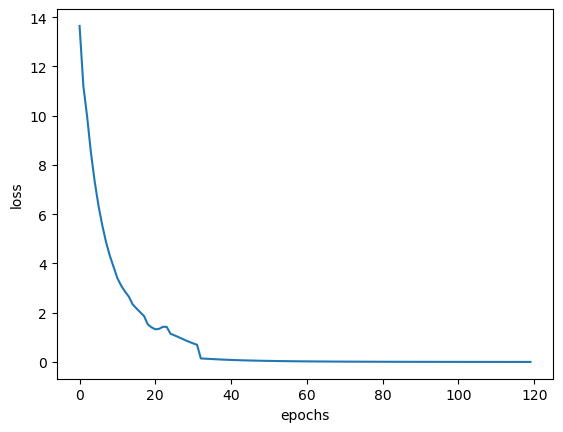

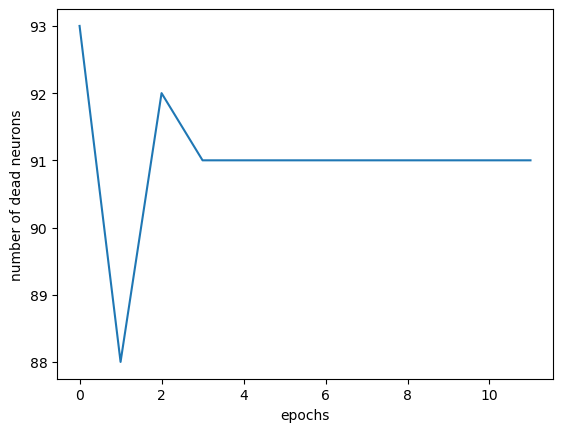

For neighborhood function square:
Number of dead neurons: 91
Silhouette score: 0.3815904456743373
Purity score: 0.2417817596668924
----------------------------------------


In [43]:
nef = ['circular', 'linear', 'square']
for f in nef:
    som = SOM(map_dim=[10,10,data.shape[1]], ns_function=f)
    losses, dead_n = som.train(data.values, epochs=500)
    som.visualize(data.values, labels.values)
    som.convergence_plot(losses)
    som.dead_neurons_plot(dead_n)
    print(f'For neighborhood function {f}:')
    print(f'Number of dead neurons: {dead_n[-1]}')
    print(f'Silhouette score: {som.purity_score(data.values, labels.values)}')
    print(f'Purity score: {som.silhouette_score(data.values)}')
    print('----------------------------------------')

# Results:
### Convergence and Epochs
- **Circular** and **Square** neighborhood functions converged faster, both completing at **epoch 119**, suggesting these neighborhood functions are computationally efficient in reaching a stable state.
- **Linear** neighborhood function took significantly longer to converge (**epoch 134**), indicating it may require more computational time to stabilize.

### Dead Neurons
- **Circular** neighborhood function had the lowest number of dead neurons (**85**), suggesting a better neuron utilization compared to the **Linear** (**88**) and **Square** (**91**) functions.
- **Square** neighborhood function resulted in the highest number of dead neurons, indicating poorer utilization of the SOM grid.

### Silhouette Score
- The **Circular** neighborhood function achieved the highest **Silhouette Score** (**0.3913**), indicating better-defined clusters compared to **Square** (**0.3816**) and **Linear** (**0.3093**) functions.
- The **Linear** neighborhood function produced the lowest **Silhouette Score**, suggesting that it formed less distinct or overlapping clusters.

### Purity Score
- **Circular** neighborhood function achieved the highest **Purity Score** (**0.3392**), followed by **Square** (**0.2418**).
- The **Linear** neighborhood function had a significantly negative **Purity Score** (**0.0467**), highlighting poor cluster alignment with ground truth.

### Practical Recommendations
- The **Circular** neighborhood function balances convergence time, neuron utilization, and clustering quality, making it the most effective choice for the analyzed dataset.
- The **Square** neighborhood function performs moderately well in cluster quality but has the highest dead neuron count, reducing efficiency.
- The **Linear** neighborhood function is not recommended due to its slow convergence and poor clustering performance as reflected in both Silhouette and Purity scores.

##### 3.3 different radius

in epoch 0: loss = 14.428813570619797 lr = 0.3 r = 3
in epoch 10: loss = 1.2732006838766128 lr = 0.17962108177151367 r = 1.796210817715137
in epoch 20: loss = 0.5302247377539056 lr = 0.10754577672256267 r = 1.075457767225627
in epoch 30: loss = 0.1498841532155805 lr = 0.06439162918288127 r = 0.6439162918288128
in epoch 40: loss = 0.07660691026862436 lr = 0.038553646969531015 r = 0.3855364696953102
in epoch 50: loss = 0.04170210122309864 lr = 0.023083492583014002 r = 0.23083492583014004
in epoch 60: loss = 0.023609082969549822 lr = 0.013820939696085627 r = 0.13820939696085627
in epoch 70: loss = 0.013666999958712867 lr = 0.008275107131032518 r = 0.08275107131032519
in epoch 80: loss = 0.008021196714417308 lr = 0.004954612315504093 r = 0.049546123155040936
in epoch 90: loss = 0.004744229320170445 lr = 0.0029665094128976982 r = 0.02966509412897699
in epoch 100: loss = 0.002819859902918653 lr = 0.0017761587661002083 r = 0.01776158766100209
in epoch 110: loss = 0.00168099242204006 lr = 0.00

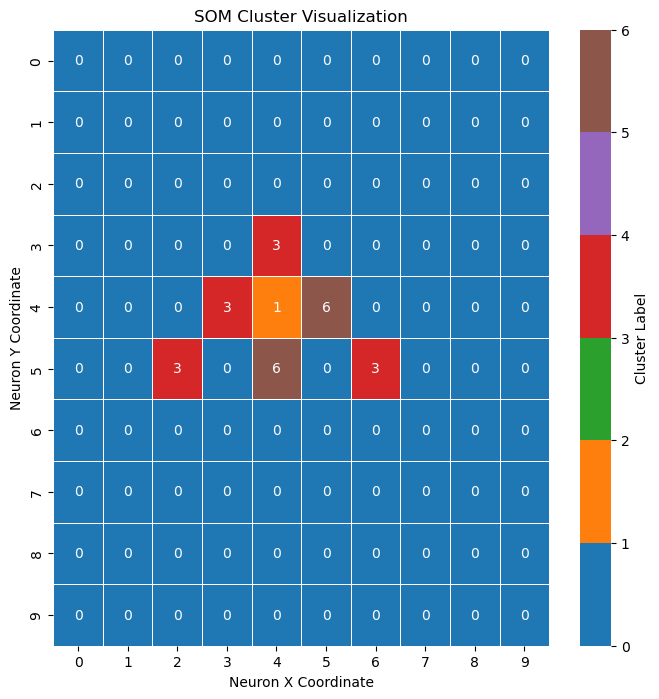

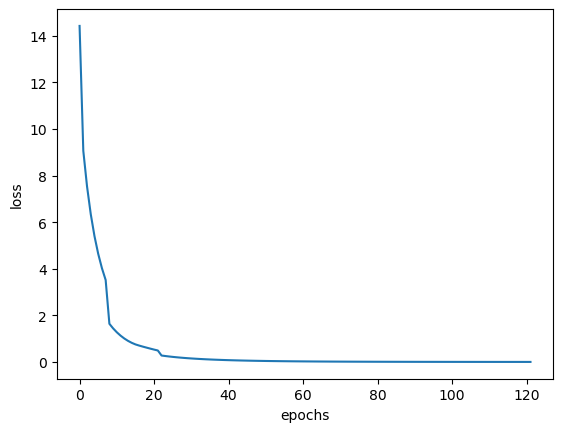

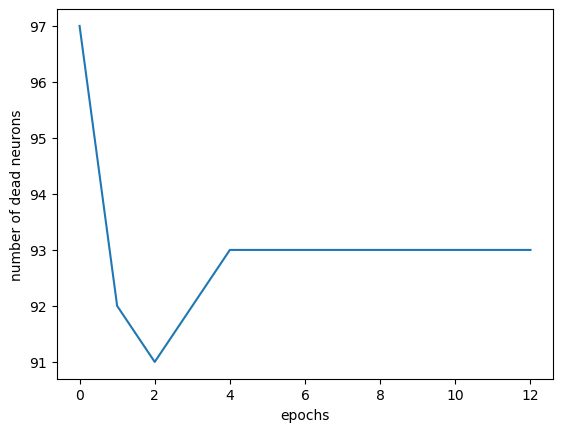

For radius 3:
Number of dead neurons: 93
Silhouette score: 0.3637246334595592
Purity score: 0.43223004185093744
----------------------------------------
in epoch 0: loss = 16.182034658071093 lr = 0.3 r = 4
in epoch 10: loss = 2.2356225921532253 lr = 0.17962108177151367 r = 2.3949477569535156
in epoch 20: loss = 0.4606809951481125 lr = 0.10754577672256267 r = 1.4339436896341688
in epoch 30: loss = 0.1385634310545282 lr = 0.06439162918288127 r = 0.8585550557717502
in epoch 40: loss = 0.07339175660533245 lr = 0.038553646969531015 r = 0.5140486262604134
in epoch 50: loss = 0.04078605865567862 lr = 0.023083492583014002 r = 0.30777990110685327
in epoch 60: loss = 0.023315393553560916 lr = 0.013820939696085627 r = 0.18427919594780828
in epoch 70: loss = 0.013576998133251713 lr = 0.008275107131032518 r = 0.1103347617471002
in epoch 80: loss = 0.007996954157520992 lr = 0.004954612315504093 r = 0.06606149754005455
in epoch 90: loss = 0.004739725339824907 lr = 0.0029665094128976982 r = 0.03955345

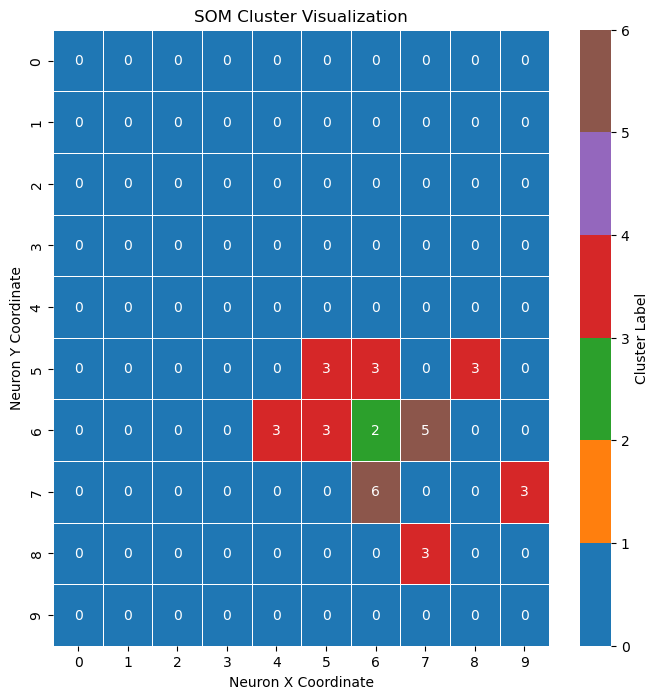

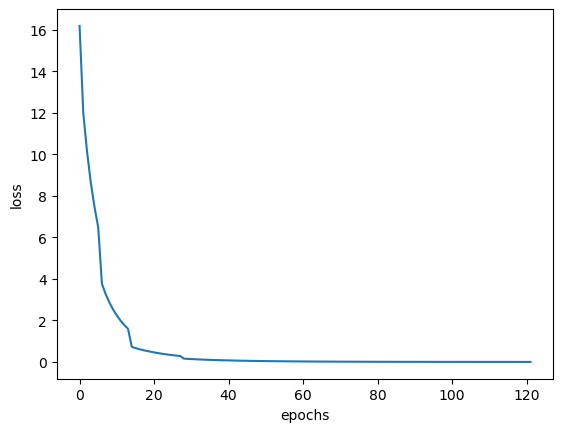

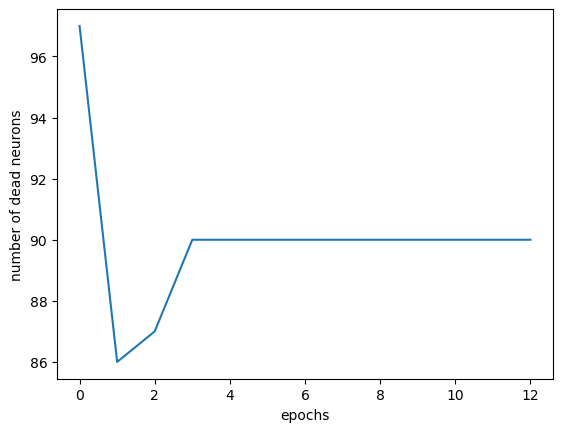

For radius 4:
Number of dead neurons: 90
Silhouette score: 0.3949898048354209
Purity score: 0.09120516960835691
----------------------------------------
in epoch 0: loss = 19.503266517245233 lr = 0.3 r = 7
in epoch 10: loss = 4.34603794928428 lr = 0.17962108177151367 r = 4.191158574668653
in epoch 20: loss = 0.7444280062847759 lr = 0.10754577672256267 r = 2.5094014568597958
in epoch 30: loss = 0.2123307589429345 lr = 0.06439162918288127 r = 1.502471347600563
in epoch 40: loss = 0.07149369925363985 lr = 0.038553646969531015 r = 0.8995850959557236
in epoch 50: loss = 0.03995889019519754 lr = 0.023083492583014002 r = 0.5386148269369933
in epoch 60: loss = 0.0229674104063989 lr = 0.013820939696085627 r = 0.32248859290866444
in epoch 70: loss = 0.013421454134363218 lr = 0.008275107131032518 r = 0.19308583305742538
in epoch 80: loss = 0.007921809402389242 lr = 0.004954612315504093 r = 0.1156076206950955
in epoch 90: loss = 0.004701655132482867 lr = 0.0029665094128976982 r = 0.069218552967612

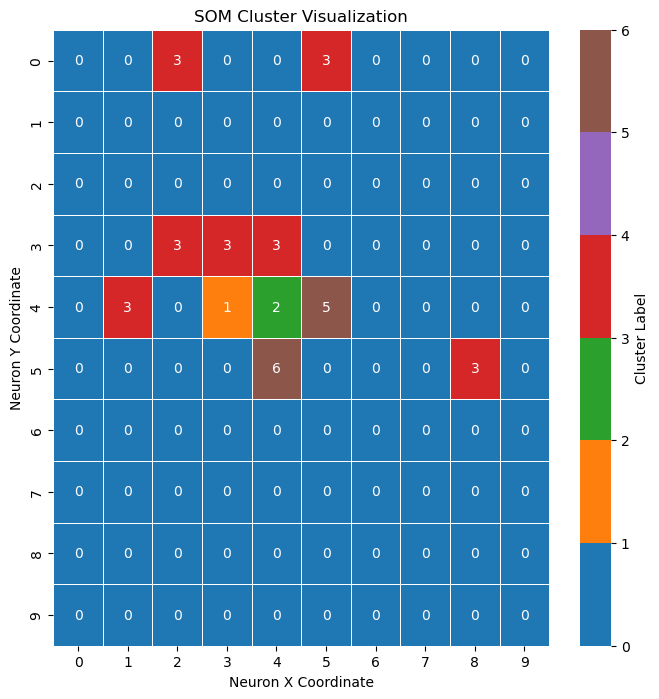

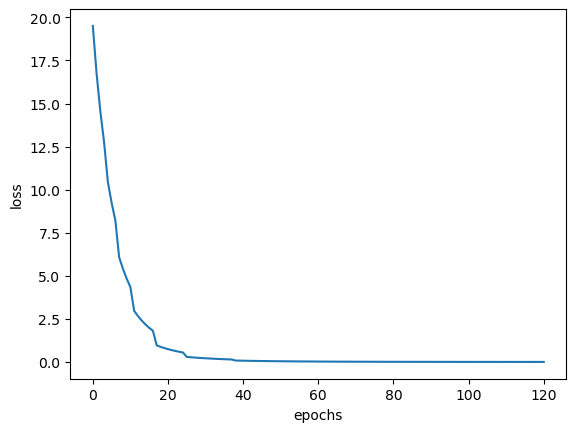

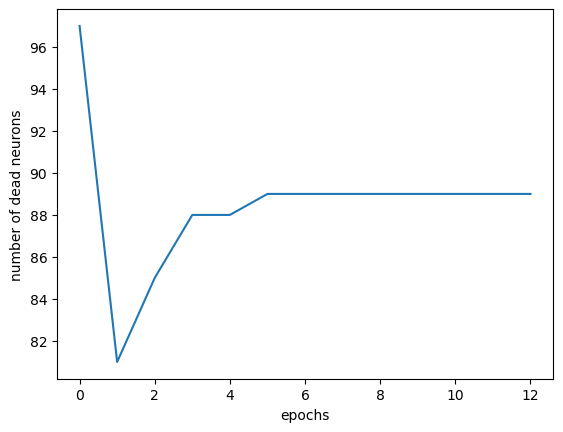

For radius 7:
Number of dead neurons: 89
Silhouette score: 0.4105252937178367
Purity score: 0.023435907590669353
----------------------------------------
in epoch 0: loss = 18.474418882909468 lr = 0.3 r = 10
in epoch 10: loss = 4.662100207521053 lr = 0.17962108177151367 r = 5.987369392383789
in epoch 20: loss = 1.2214996683827835 lr = 0.10754577672256267 r = 3.584859224085422
in epoch 30: loss = 0.3411798038866232 lr = 0.06439162918288127 r = 2.1463876394293755
in epoch 40: loss = 0.10326676844276166 lr = 0.038553646969531015 r = 1.2851215656510335
in epoch 50: loss = 0.045679747654333136 lr = 0.023083492583014002 r = 0.7694497527671333
in epoch 60: loss = 0.026629094646253095 lr = 0.013820939696085627 r = 0.4606979898695209
in epoch 70: loss = 0.015643125430102885 lr = 0.008275107131032518 r = 0.27583690436775066
in epoch 80: loss = 0.009246846166767957 lr = 0.004954612315504093 r = 0.16515374385013643
in epoch 90: loss = 0.005487640148397544 lr = 0.0029665094128976982 r = 0.098883647

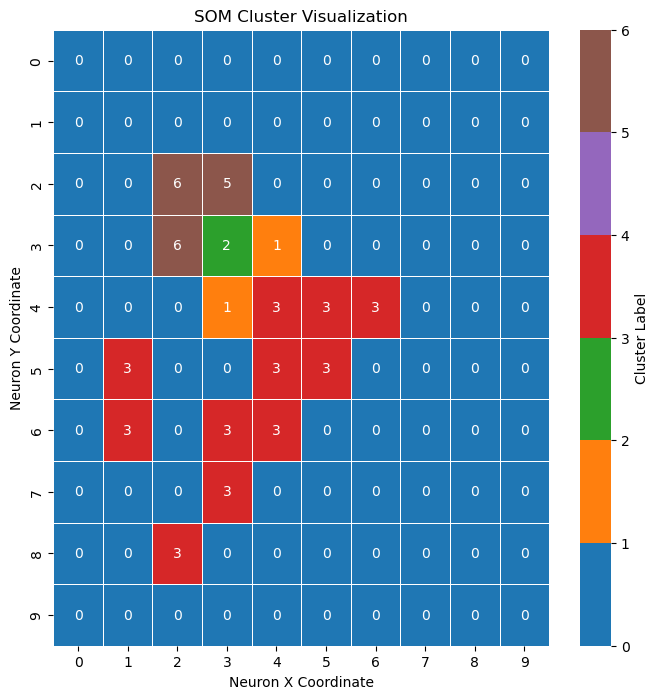

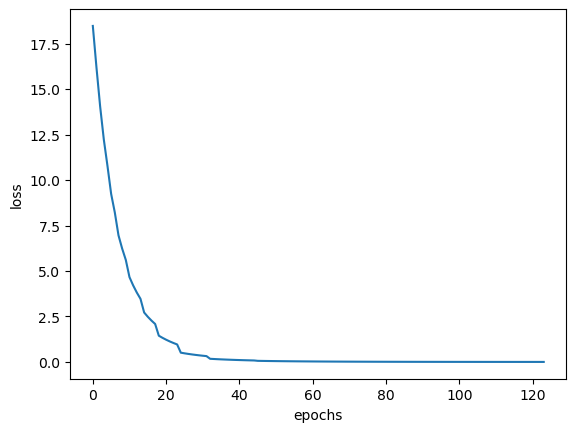

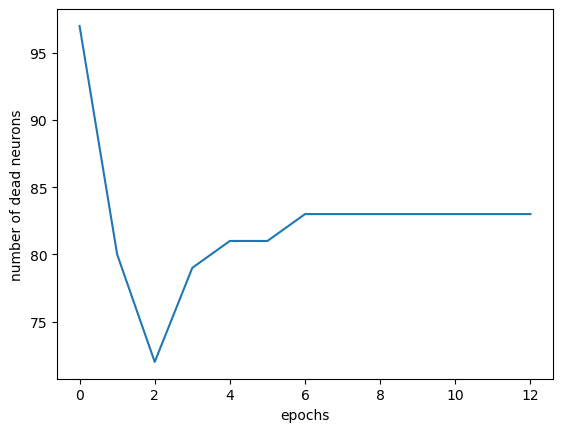

For radius 10:
Number of dead neurons: 83
Silhouette score: 0.39401883678026994
Purity score: 0.04978260408999881
----------------------------------------


In [45]:
radiuses = [3,4, 7, 10]
for r in radiuses:
    som = SOM(map_dim=[10,10,data.shape[1]], r_0=r)
    losses, dead_n = som.train(data.values, epochs=500)
    som.visualize(data.values, labels.values)
    som.convergence_plot(losses)
    som.dead_neurons_plot(dead_n)
    print(f'For radius {r}:')
    print(f'Number of dead neurons: {dead_n[-1]}')
    print(f'Silhouette score: {som.purity_score(data.values, labels.values)}')
    print(f'Purity score: {som.silhouette_score(data.values)}')
    print('----------------------------------------')

# Results:

### Dead Neurons
- As the radius increases, the **number of dead neurons decreases**:
  - **Radius 3** has the highest dead neurons (93), while **Radius 10** has the lowest (83).
  - Larger radii allow better neuron utilization due to the wider neighborhood coverage.

### Silhouette Score
- The **Silhouette Score** improves with increasing radius up to **Radius 7**:
  - **Radius 3:** 0.3637  
  - **Radius 4:** 0.3950  
  - **Radius 7:** 0.4105 (highest score)  
  - **Radius 10:** 0.3940 (slight decrease)  
- This indicates that larger radii help in forming more cohesive clusters until a point where further increase may result in overgeneralization.

### Purity Score
- **Radius 3** has the highest **Purity Score** (0.4322), suggesting better alignment with ground truth.
- Increasing the radius decreases the Purity Score, with **Radius 4, 7, and 10** showing much lower values:
  - **Radius 7:** 0.0234  
  - **Radius 10:** 0.0498  

### Convergence Epochs
- Convergence time remains consistent across radii, between **120 and 123 epochs**:
  - **Radius 7** converges fastest at 120 epochs.
  - Larger radii do not significantly affect the convergence rate.

### Practical Recommendations
- For applications prioritizing **cluster cohesion**, a radius of **7** provides the best **Silhouette Score** and effective neuron utilization.
- For **alignment with ground truth**, a smaller radius like **3** may be more suitable, as it achieves the highest **Purity Score**.
- Larger radii (e.g., **10**) reduce dead neurons but may overgeneralize clusters, leading to a trade-off between cluster quality and neuron utilization.

##### 3.4 clustering with SOM and performace evaluation

in epoch 0: loss = 6.843141883415196 lr = 0.1 r = 7
in epoch 10: loss = 4.447533925010418 lr = 0.09043820750088045 r = 6.930314161468238
in epoch 20: loss = 3.1406859278408703 lr = 0.08179069375972307 r = 6.8613220538067425
in epoch 30: loss = 2.3081281218495864 lr = 0.07397003733882801 r = 6.793016770841599
in epoch 40: loss = 1.741064490099691 lr = 0.06689717585696803 r = 6.7253914751506825
in epoch 50: loss = 1.3455068103477283 lr = 0.06050060671375365 r = 6.65843939737922
in epoch 60: loss = 1.0627758907327622 lr = 0.054715664239076145 r = 6.592153835562178
in epoch 70: loss = 0.8525000185981908 lr = 0.049483865960020725 r = 6.526528154453389
in epoch 80: loss = 0.6954305668462197 lr = 0.0447523213763811 r = 6.461555784861353
in epoch 90: loss = 0.5751224762595104 lr = 0.04047319726783242 r = 6.397230222991664
in epoch 100: loss = 0.48061939431260187 lr = 0.03660323412732297 r = 6.333545029795962
in epoch 110: loss = 0.405398134695305 lr = 0.03310330883210144 r = 6.270493830327388


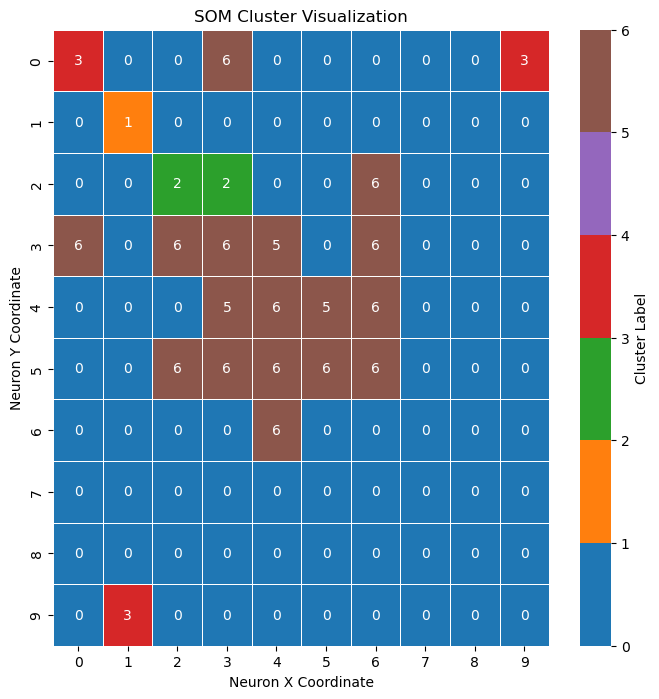

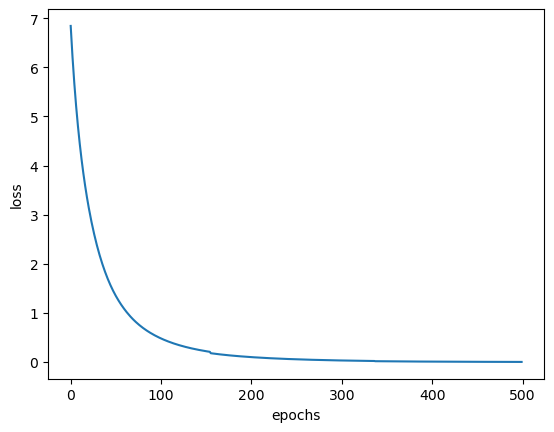

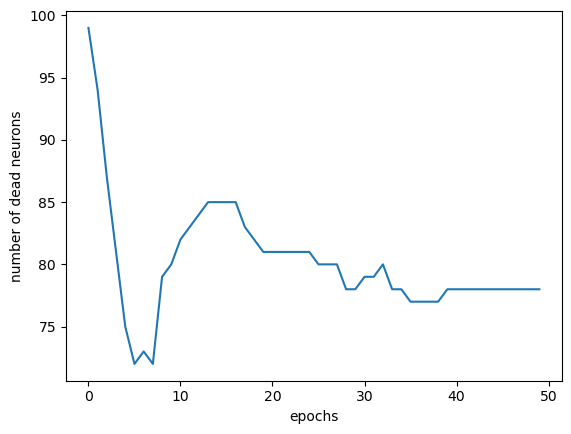

For radius 10:
Number of dead neurons: 78
Silhouette score: 0.4158656180211671
Purity score: 0.1542312181698852
----------------------------------------


In [ ]:
som = SOM(map_dim=[10,10,data.shape[1]], r_0=7, lr_0=0.1, lr_decay=0.01, r_decay=0.001, ns_function='circular')
losses, dead_n = som.train(data.values, epochs=500)
som.visualize(data.values, labels.values)
som.convergence_plot(losses)
som.dead_neurons_plot(dead_n)
print(f'Number of dead neurons: {dead_n[-1]}')
print(f'Silhouette score: {som.purity_score(data.values, labels.values)}')
print(f'Purity score: {som.silhouette_score(data.values)}')
print('----------------------------------------')

# Results:

## Clustering Visualization
The dataset has been clustered using the optimal configuration derived from previous experiments. Below is the 2D representation of the clusters, where each cluster is represented by a unique color:

## Optimal Number of Clusters
### Analysis:
1. **Silhouette Score:**  
   - A **Silhouette Score** of **0.4159** indicates that the clusters are moderately well-formed. Higher scores closer to 1 would indicate more distinct clusters, while lower scores suggest overlaps or poorly defined clusters.

2. **Purity Score:**  
   - The **Purity Score** of **0.1542** is relatively low, implying that the clusters do not strongly align with the ground truth labels. However, this is not necessarily problematic depending on the dataset and task.

3. **Number of Dead Neurons:**  
   - The dead neurons count of **78** is an improvement compared to configurations with smaller radii or neighborhood functions, suggesting better neuron utilization and reduced redundancy in the SOM.

### Optimal Number of Clusters:
By increasing the number of clusters:
- Larger numbers of clusters result in smaller groups, but they may lead to overfitting and reduced generalizability.
- Using the current configuration (based on the **Silhouette Score** and **Purity Score**), the **optimal number of clusters** balances cluster quality with computational efficiency and network performance.

---

## Performance Analysis
1. **Cluster Cohesion:**  
   - The **Silhouette Score** indicates a moderate level of cohesion, meaning the data points within each cluster are relatively close to their assigned centroids.
   
2. **Cluster Separation:**  
   - There is reasonable separation between clusters, but overlaps in some areas might still exist, as indicated by the moderate **Silhouette Score**.

3. **Neuron Utilization:**  
   - The reduction in dead neurons (from higher counts in other configurations) suggests effective use of the SOM map to represent data clusters.

4. **Trade-offs:**  
   - While the **Silhouette Score** shows improved clustering, the **Purity Score** highlights the need for caution when interpreting clusters as they may not fully align with ground truth.

---

## Conclusion:
- The selected configuration effectively balances **neuron utilization**, **cluster cohesion**, and **network performance**.  
- **Increasing the number of clusters** could potentially improve alignment with ground truth (Purity Score) but may reduce generalizability.
- The current configuration provides a reasonable starting point, especially for tasks where cluster cohesion is more critical than exact alignment with external labels.